tgb - 12/17/19 - The goal of this notebook is to code the UCnet and ACnet versions of the RH -> dRH/dt network. The constraints are linear in q_v and therefore strongly non-linear in RH. The steps are as follows:  
1) Code inversion RH->qv and dRHdt->dqvdt in numpy  
2) Convert layers in tensorflow   
3) Test network and conservation properties  
4) Train the new network for 15 epochs and save state of best validation loss

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W0107 04:16:10.309566 23040240617280 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0107 04:16:10.310425 23040240617280 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W0107 04:16:10.311039 23040240617280 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Inversion layers

Load data

In [2]:
data = xr.open_mfdataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-03-01-00000.nc",\
                         decode_times=False)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


Save hyam and hybm for later use, inspired from how hyai and hybi are saved

In [3]:
path = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain/'
path_hyai = 'hyam_hybm.pkl'
hf = open(path+path_hyai,'rb')
test = pickle.load(hf)

In [4]:
test[0]

array([0.00364347, 0.00759482, 0.01435663, 0.02461222, 0.0382683 ,
       0.05459548, 0.07201245, 0.08782123, 0.10331713, 0.12154724,
       0.14299404, 0.16822508, 0.17823067, 0.17032433, 0.16102291,
       0.15008029, 0.13720686, 0.12206194, 0.10424471, 0.08497915,
       0.0665017 , 0.05019679, 0.03718866, 0.02843195, 0.02220898,
       0.01640738, 0.01107456, 0.00625495, 0.00198941, 0.        ])

In [5]:
# path_hyam = 'hyam_hybm.pkl'
# hf = open(path+path_hyam,'wb')
# pickle.dump([data.hyam.values,data.hybm.values],hf)
# hf.close()

Convert specific humidity to relative humidity and back

Text(0.5, 0.98, 'Histogram of Specific humidity')

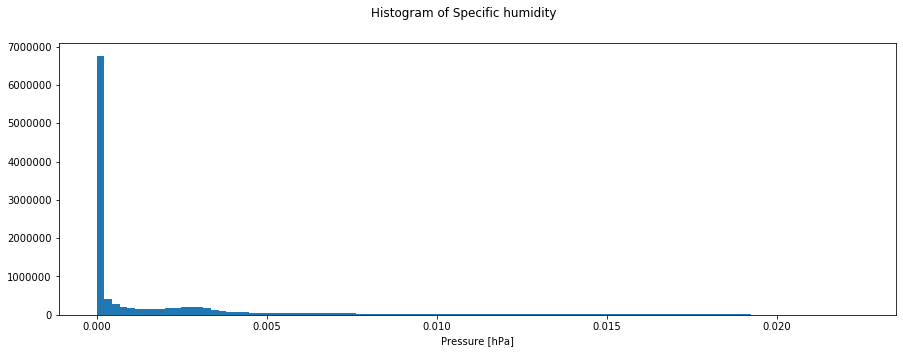

In [6]:
plt.figure(figsize=(15,5))
plt.hist(data.QAP.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Specific humidity")

Forward version

In [7]:
# SAM Constants, TODO = Check that they are the same in SPCAM
# In functions
a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
c_liq = -80
c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
# General
cp = 1.004e3
g = 9.81
Lc = 2.5104e6
Lf = 0.3336e6
Ls = 2.8440e6
R = 287
Rv = 461
T0 = 273.16
T0p = 283.16
T00 = 253.16
T00p = 268.16

In [8]:
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [9]:
def deliqdT(T):
    a_liq = np.array([-0.599634321e-17,-0.792933209e-14,-0.604119582e-12,0.385208005e-9,0.103167413e-6,0.121167162e-4,0.794747212e-3,0.285976452e-1,0.443956472])
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [10]:
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [11]:
def deicedT(T):
    a_ice = np.array([0.497275778e-16,0.390204672e-13,0.132073448e-10,0.255653718e-8,0.312668753e-6,0.249065913e-4,0.126710138e-2,0.377174432e-1,0.503223089])
    c_ice = np.array([273.15,185,-100,0.0013186,2.60269e-05,1.28676e-07])
    T0 = 273.16
    return (T>c_ice[0])*deliqdT(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [12]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

In [22]:
def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = np.moveaxis((hyam*P0+hybm*PS).values,0,1) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))

In [ ]:
def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    #p = np.moveaxis((hyam*P0+hybm*PS),0,1) # Total pressure (Pa)
    p = hyam*P0+hybm*PS
    #return R*esat(T)*RH/(Rv*p)
    # DEBUG 1
    # return esat(T)

In [11]:
RH0 = RH(data.TAP.values,data.QAP,data.P0,data.PS,data.hyam,data.hybm)

In [12]:
RH0

<xarray.DataArray 'QAP' (time: 48, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(48, 30, 64, 128), dtype=float64, chunksize=(48, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) float64 59.0 59.02 59.04 59.06 ... 59.92 59.94 59.96 59.98

Text(0.5, 0.98, 'Histogram of Relative humidity')

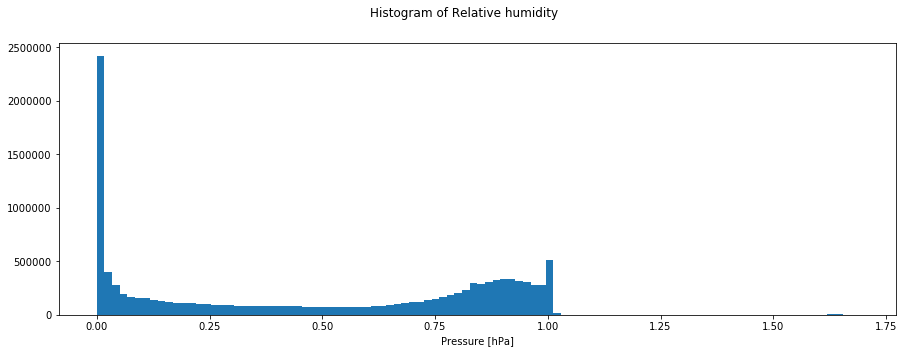

In [13]:
plt.figure(figsize=(15,5))
plt.hist(RH0.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Relative humidity")

Backward version

In [23]:
def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    #p = np.moveaxis((hyam*P0+hybm*PS),0,1) # Total pressure (Pa)
    p = hyam*P0+hybm*PS
    #return R*esat(T)*RH/(Rv*p)
    # DEBUG 1
    # return esat(T)

In [15]:
QV0 = qv(data.TAP.values,RH0,data.P0,data.PS,data.hyam,data.hybm)

Text(0.5, 0.98, 'Histogram of Specific humidity')

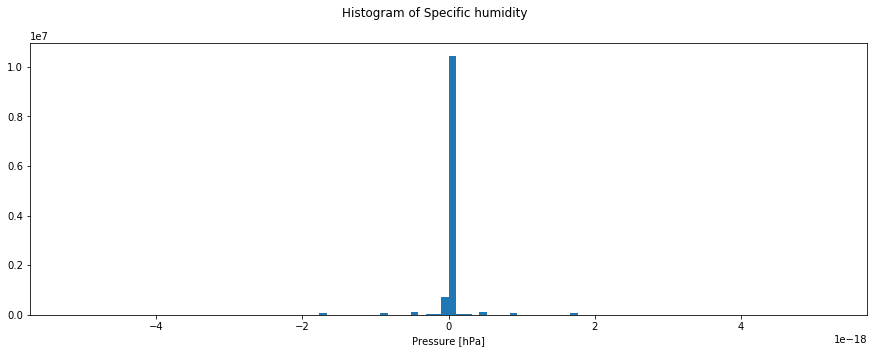

In [16]:
plt.figure(figsize=(15,5))
#plt.hist(QV0.values.flatten(),bins=100)
#plt.hist(data.QAP.values.flatten(),bins=100)
plt.hist(QV0.values.flatten()-data.QAP.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Specific humidity")

# 2) Convert to tensorflow layers between specific and relative humidities

This layer takes an input vector x of size 304 similar to our reference network, except that the specific humidity vector of size 30 is replaced with a relative humidity vector of size 30. The goal of this layer is to convert relative humidity back to specific humidity.

## 2.1) Moist thermodynamics library in tensorflow

In [30]:
# Moist thermodynamics library adapted to tf
def eliq(T):
    a_liq = np.float32(np.array([-0.976195544e-15,-0.952447341e-13,\
                                 0.640689451e-10,\
                      0.206739458e-7,0.302950461e-5,0.264847430e-3,\
                      0.142986287e-1,0.443987641,6.11239921]));
    c_liq = np.float32(-80.0)
    T0 = np.float32(273.16)
    return np.float32(100.0)*tfm.polyval(a_liq,tfm.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.float32(np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,\
                      0.602588177e-7,0.615021634e-5,0.420895665e-3,\
                      0.188439774e-1,0.503160820,6.11147274]));
    c_ice = np.float32(np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07]))
    T0 = np.float32(273.16)
    return tf.where(T>c_ice[0],eliq(T),\
                   tf.where(T<=c_ice[1],np.float32(100.0)*(c_ice[3]+tfm.maximum(c_ice[2],T-T0)*\
                   (c_ice[4]+tfm.maximum(c_ice[2],T-T0)*c_ice[5])),\
                           np.float32(100.0)*tfm.polyval(a_ice,T-T0)))

def esat(T):
    T0 = np.float32(273.16)
    T00 = np.float32(253.16)
    omtmp = (T-T00)/(T0-T00)
    omega = tfm.maximum(np.float32(0.0),tfm.minimum(np.float32(1.0),omtmp))

    return tf.where(T>T0,eliq(T),tf.where(T<T00,eice(T),(omega*eliq(T)+(1-omega)*eice(T))))

def qv(T,RH,P0,PS,hyam,hybm):
    
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = tf.cast(T,tf.float32)
    RH = tf.cast(RH,tf.float32)
    p = tf.cast(p,tf.float32)
    
    return R*esat(T)*RH/(Rv*p)
    # DEBUG 1
    # return esat(T)
    
def RH(T,qv,P0,PS,hyam,hybm):
    R = np.float32(287.0)
    Rv = np.float32(461.0)
    p = P0 * hyam + PS[:, None] * hybm # Total pressure (Pa)
    
    T = tf.cast(T,tf.float32)
    qv = tf.cast(qv,tf.float32)
    p = tf.cast(p,tf.float32)
    
    return Rv*p*qv/(R*esat(T))

## 2.2) Custom layers

In [56]:
class RH2QV(Layer):
    def __init__(self, inp_subQ, inp_divQ, inp_subRH, inp_divRH, hyam, hybm, **kwargs):
        """
        Call using ([input])
        Assumes
        prior: [RHBP, 
        QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, 
        Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
        Returns
        post(erior): [QBP, 
        QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, 
        Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
        """
        self.inp_subQ, self.inp_divQ, self.inp_subRH, self.inp_divRH, self.hyam, self.hybm = \
            np.array(inp_subQ), np.array(inp_divQ), np.array(inp_subRH), np.array(inp_divRH), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(90,120)
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ),
                  'inp_subRH': list(self.inp_subRH), 'inp_divRH': list(self.inp_divRH),
                  'hyam': list(self.hyam),'hybm': list(self.hybm)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        prior, = arrs
        
        Tprior = prior[:,self.TBP_idx]*self.inp_divRH[self.TBP_idx]+self.inp_subRH[self.TBP_idx]
        RHprior = prior[:,self.QBP_idx]*self.inp_divRH[self.QBP_idx]+self.inp_subRH[self.QBP_idx]
        PSprior = prior[:,self.PS_idx]*self.inp_divRH[self.PS_idx]+self.inp_subRH[self.PS_idx]
        qvprior = (qv(Tprior,RHprior,P0,PSprior,self.hyam,self.hybm)-\
                    self.inp_subQ[self.QBP_idx])/self.inp_divQ[self.QBP_idx]
        
        post = tf.concat([tf.cast(qvprior,tf.float32),prior[:,30:]], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape + 1"""
        return (input_shape[0][0])

In [57]:
class dQVdt2dRHdt(Layer):
    def __init__(self, inp_subQ, inp_divQ, norm_qQ, inp_subRH, inp_divRH, norm_qRH, hyam, hybm, **kwargs):
        """
        Call using ([input_qv,output])
        Assumes
        prior: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [dRHdt, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_subQ, self.inp_divQ, self.norm_qQ, \
        self.inp_subRH, self.inp_divRH, self.norm_qRH, \
        self.hyam, self.hybm = \
            np.array(inp_subQ), np.array(inp_divQ), np.array(norm_qQ), \
        np.array(inp_subRH), np.array(inp_divRH), np.array(norm_qRH), \
        np.array(hyam), np.array(hybm)
        # Define variable indices here
        # Input
        self.PHQ_idx = slice(0,30)
        
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(90,120)
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ),
                  'norm_qQ': list(self.norm_qQ),
                  'inp_subRH': list(self.inp_subRH), 'inp_divRH': list(self.inp_divRH),
                  'norm_qRH': list(self.norm_qRH), 
                  'hyam': list(self.hyam),'hybm': list(self.hybm)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        inp, prior = arrs
        
        # Assumes the input has specific humidity in positions[0,30]
        Tprior = inp[:,self.TBP_idx]*self.inp_divQ[self.TBP_idx]+self.inp_subQ[self.TBP_idx]
        PSprior = inp[:,self.PS_idx]*self.inp_divQ[self.PS_idx]+self.inp_subQ[self.PS_idx]
        dqvdtprior = prior[:,self.QBP_idx]/self.norm_qQ
        
        dRHdtprior = RH(Tprior,dqvdtprior,P0,PSprior,self.hyam,self.hybm)*self.norm_qRH
        post = tf.concat([dRHdtprior,prior[:,30:]], axis=1)
        
        return post

    def compute_output_shape(self,input_shape):
        """Input shape"""
        return (input_shape[0][0],input_shape[0][1])

# 3) Code UCnet using RH

Generators using RH

In [33]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [34]:
scale_dict['dRHdt'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%  

In [35]:
scale_dict

{'PHQ': array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
        3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
        4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
        8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
        1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
        1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
        6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
        4.4820160e+08, 3.7970438e+08], dtype=float32),
 'PHCLDLIQ': array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
        3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
        4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
        8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
        1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
        1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
        6.7863763e+08, 6.2842387e+08, 5.73

In [36]:
#save_pickle('./nn_config/scale_dicts/035_RH_scaling.pkl', scale_dict)

In [37]:
in_vars = ['RH', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['dRHdt', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [38]:
TRAINFILE = '8col009RH_01_train.nc'
NORMFILE = '8col009RH_01_norm.nc'
VALIDFILE = '8col009RH_01_valid.nc'

In [39]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

OSError: [Errno -101] NetCDF: HDF error: b'/local/Tom.Beucler/SPCAM_PHYS/8col009RH_01_train.nc'

In [40]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

OSError: [Errno -101] NetCDF: HDF error: b'/local/Tom.Beucler/SPCAM_PHYS/8col009RH_01_valid.nc'

Generators using Q

In [41]:
TRAINFILEQ = '8col009_01_train.nc'
VALIDFILEQ = '8col009_01_valid.nc'
NORMFILEQ = '8col009_01_norm.nc'

In [15]:
scale_dictQ = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [16]:
in_varsQ = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_varsQ = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [17]:
train_genQ = DataGenerator(
    data_fn = TRAINDIR+TRAINFILEQ,
    input_vars = in_varsQ,
    output_vars = out_varsQ,
    norm_fn = TRAINDIR+NORMFILEQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dictQ,
    batch_size=1024,
    shuffle=True
)

In [18]:
valid_genQ = DataGenerator(
    data_fn = TRAINDIR+VALIDFILEQ,
    input_vars = in_varsQ,
    output_vars = out_varsQ,
    norm_fn = TRAINDIR+NORMFILEQ,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dictQ,
    batch_size=1024,
    shuffle=True
)

Confirm that shapes are OK

In [16]:
print(train_gen[50][0].shape)
print(train_gen[50][1].shape)

(1024, 304)
(1024, 218)


In [17]:
print(valid_gen[50][0].shape)
print(valid_gen[50][1].shape)

(1024, 304)
(1024, 218)


In [18]:
print(train_genQ[50][0].shape)
print(train_genQ[50][1].shape)

(1024, 304)
(1024, 218)


In [19]:
print(valid_genQ[50][0].shape)
print(valid_genQ[50][1].shape)

(1024, 304)
(1024, 218)


UCnet structure

In [42]:
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(218, activation='linear')(densout)
UCnet = tf.keras.models.Model(inp, out)

W0107 04:20:07.278859 23040240617280 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [58]:
inp = Input(shape=(304,))
inpQ = RH2QV(inp_subQ=train_genQ.input_transform.sub, 
             inp_divQ=train_genQ.input_transform.div, 
             inp_subRH=train_gen.input_transform.sub, 
             inp_divRH=train_gen.input_transform.div, 
             hyam=hyam, hybm=hybm)([inp])
densout = Dense(512, activation='linear')(inpQ)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
outQ = Dense(218, activation='linear')(densout)
out = dQVdt2dRHdt(inp_subQ=train_genQ.input_transform.sub,
                  inp_divQ=train_genQ.input_transform.div,
                  norm_qQ=scale_dictQ['PHQ'], 
                  inp_subRH=train_gen.input_transform.sub, 
                  inp_divRH=train_gen.input_transform.div, 
                  norm_qRH=scale_dict['dRHdt'], 
                  hyam=hyam, hybm=hybm)([inpQ, outQ])
UCnetRH2Q = tf.keras.models.Model(inp, out)

In [44]:
UCnet.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               156160    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0   

In [45]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'035_UCnet.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [50]:
UCnet.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [51]:
Nep = 10
UCnet.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/10
9120/9120 [==============================] - 256s 28ms/step - loss: 107.9758 - val_loss: 85.5780
Epoch 2/10
9120/9120 [==============================] - 225s 25ms/step - loss: 87.3352 - val_loss: 76.6641
Epoch 3/10
9120/9120 [==============================] - 226s 25ms/step - loss: 80.4424 - val_loss: 72.8080
Epoch 4/10
9120/9120 [==============================] - 225s 25ms/step - loss: 76.6570 - val_loss: 74.5833
Epoch 5/10
9120/9120 [==============================] - 225s 25ms/step - loss: 74.1997 - val_loss: 70.5920
Epoch 6/10
9120/9120 [==============================] - 226s 25ms/step - loss: 72.4749 - val_loss: 69.8499
Epoch 7/10
9120/9120 [==============================] - 227s 25ms/step - loss: 71.2432 - val_loss: 67.4036
Epoch 8/10
9120/9120 [==============================] - 226s 25ms/step - loss: 70.2651 - val_loss: 68.6109
Epoch 9/10
9120/9120 [==============================] - 224s 25ms/step - loss: 69.4793 - val_loss: 67.5296
Epoch 10/10
9120/9120 [=============

UCnet using conversion layers

In [59]:
UCnetRH2Q.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 304)]        0                                            
__________________________________________________________________________________________________
r_h2qv_4 (RH2QV)                (None, 304)          0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          156160      r_h2qv_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 512)          0           dense_12[0][0]                   
____________________________________________________________________________________________

In [60]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'UCnetNL.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [61]:
UCnetRH2Q.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [62]:
Nep = 10
UCnetRH2Q.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/10
9120/9120 [==============================] - 250s 27ms/step - loss: 256.9746 - val_loss: 125.8779
Epoch 2/10
9120/9120 [==============================] - 247s 27ms/step - loss: 105.6867 - val_loss: 97.9140
Epoch 3/10
9120/9120 [==============================] - 249s 27ms/step - loss: 93.4167 - val_loss: 90.5187
Epoch 4/10
9120/9120 [==============================] - 247s 27ms/step - loss: 87.9379 - val_loss: 119.0055
Epoch 5/10
9120/9120 [==============================] - 247s 27ms/step - loss: 84.6158 - val_loss: 85.6420
Epoch 6/10
9120/9120 [==============================] - 247s 27ms/step - loss: 82.3190 - val_loss: 92.5707
Epoch 7/10
9120/9120 [==============================] - 245s 27ms/step - loss: 80.3897 - val_loss: 74.7415
Epoch 8/10
9120/9120 [==============================] - 248s 27ms/step - loss: 79.0741 - val_loss: 76.5630
Epoch 9/10
9120/9120 [==============================] - 244s 27ms/step - loss: 78.0215 - val_loss: 82.9907
Epoch 10/10
9120/9120 [==========

ACnet using the RH2Q conversion

In [63]:
inp = Input(shape=(304,))
inpQ = RH2QV(inp_subQ=train_genQ.input_transform.sub, 
             inp_divQ=train_genQ.input_transform.div, 
             inp_subRH=train_gen.input_transform.sub, 
             inp_divRH=train_gen.input_transform.div, 
             hyam=hyam, hybm=hybm)([inp])
densout = Dense(512, activation='linear')(inpQ)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
surfout = SurRadLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpQ, densout])
massout = MassConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpQ, surfout])
enthout = EntConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpQ, massout])
outQ = Dense(218, activation='linear')(enthout)
out = dQVdt2dRHdt(inp_subQ=train_genQ.input_transform.sub,
                  inp_divQ=train_genQ.input_transform.div,
                  norm_qQ=scale_dictQ['PHQ'], 
                  inp_subRH=train_gen.input_transform.sub, 
                  inp_divRH=train_gen.input_transform.div, 
                  norm_qRH=scale_dict['dRHdt'], 
                  hyam=hyam, hybm=hybm)([inpQ, outQ])
ACnetRH2Q = tf.keras.models.Model(inp, out)

In [64]:
ACnetRH2Q.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 304)]        0                                            
__________________________________________________________________________________________________
r_h2qv_5 (RH2QV)                (None, 304)          0           input_8[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 512)          156160      r_h2qv_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 512)          0           dense_18[0][0]                   
____________________________________________________________________________________________

In [67]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'ACnetNL.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [68]:
ACnetRH2Q.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [69]:
Nep = 10
ACnetRH2Q.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/10
9120/9120 [==============================] - 281s 31ms/step - loss: 351.3682 - val_loss: 114.9190
Epoch 2/10
9120/9120 [==============================] - 277s 30ms/step - loss: 119.4794 - val_loss: 95.8634
Epoch 3/10
9120/9120 [==============================] - 274s 30ms/step - loss: 102.3584 - val_loss: 121.1898
Epoch 4/10
9120/9120 [==============================] - 273s 30ms/step - loss: 94.4301 - val_loss: 83.3368
Epoch 5/10
9120/9120 [==============================] - 455s 50ms/step - loss: 90.1186 - val_loss: 88.3457
Epoch 6/10
9120/9120 [==============================] - 523s 57ms/step - loss: 87.2790 - val_loss: 88.0935
Epoch 7/10
9120/9120 [==============================] - 453s 50ms/step - loss: 84.9181 - val_loss: 80.1676
Epoch 8/10
9120/9120 [==============================] - 446s 49ms/step - loss: 83.1070 - val_loss: 75.0563
Epoch 9/10
9120/9120 [==============================] - 522s 57ms/step - loss: 81.6919 - val_loss: 76.8089
Epoch 10/10
9120/9120 [=========

# 4) Compare performances of UCnet and UCnetRH2Q

## 4.1) R2 of vertical profiles

tgb - 1/6/2020 - It looks like the layers above cannot be saved statically as is. Therefore, we will do all of our evaluation using eager execution.

In [16]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
config_file = ['8col_rad_tbeucler_local-RH_PostProc.yml',
               '8col_rad_tbeucler_local-RH_PostProc.yml',
               '8col_rad_tbeucler_local-RH_PostProc.yml']
data_file = ['8col009RH_01_train.nc',
            '8col009RH_01_valid.nc',
            '8col009RH_01_test.nc']
NNarray = ['035_Test01.hdf5','035_Test02.hdf5','035_Test03.hdf5']
NNname = ['UCnet','UCnet_{NL}','ACnet_{NL}']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'RH2QV':RH2QV,'dQVdt2dRHdt':dQVdt2dRHdt,
           'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH}

In [17]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        md[NNs][data[13:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/'+config_file[i],
                                                '/local/Tom.Beucler/SPCAM_PHYS/'+data)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  035_Test01.hdf5
data name is  8col009RH_01_train.nc
data name is  8col009RH_01_valid.nc
data name is  8col009RH_01_test.nc


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  035_Test02.hdf5


TypeError: You are attempting to use Python control flow in a layer that was not declared to be dynamic. Pass `dynamic=True` to the class constructor.
Encountered error:
"""
in converted code:

    <ipython-input-11-8978d719aed6>:38 call *
        prior, = arrs
    /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:477 __iter__
        "Tensor objects are only iterable when eager execution is "

    TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

"""

tgb - 1/6/2020 - Use eager execution on the test data

## 4.2) Mean-squared error and conservation penalty

# 10) Debugging

## 10.1) Tensorflow debug

### 10.1.1) Debug RH2QV

In [24]:
inp = Input(shape=(304,))
tmp = RH2QV(inp_subQ=train_genQ.input_transform.sub, 
             inp_divQ=train_genQ.input_transform.div, 
             inp_subRH=train_gen.input_transform.sub, 
             inp_divRH=train_gen.input_transform.div, 
             hyam=hyam, hybm=hybm)([inp])
Test = tf.keras.models.Model(inp, tmp)

In [25]:
Test.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
r_h2qv_2 (RH2QV)             (None, 304)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [26]:
Test.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [27]:
X = train_gen[56][0]

In [28]:
qvtest = Test.predict_on_batch(X)

In [29]:
qvtest[25,:30]

array([1.9030899e-06, 1.8915148e-06, 1.7339299e-06, 1.7308904e-06,
       1.6900492e-06, 1.6526891e-06, 1.6435984e-06, 1.6420252e-06,
       1.6418791e-06, 1.6428154e-06, 1.6598168e-06, 1.7643989e-06,
       2.2018805e-06, 6.5068339e-06, 2.4600353e-05, 4.3809756e-05,
       7.1979382e-05, 3.0872758e-04, 1.2588734e-03, 4.5175510e-03,
       1.1704578e-02, 2.2368515e-02, 3.8449377e-02, 6.0668945e-02,
       9.1321923e-02, 1.4544553e-01, 2.4266730e-01, 4.7690892e-01,
       1.5808966e+00, 3.5272056e+03], dtype=float32)

In [58]:
X[25,:30]

array([-0.06297259, -0.05136243, -0.10149719, -0.05036039, -0.06315299,
       -0.09800371, -0.10595452, -0.13731119, -0.1159419 , -0.13201046,
       -0.14780387, -0.16423412, -0.18461413, -0.17864311, -0.01712106,
       -0.00878462, -0.11884584,  0.06055145,  0.14901265,  0.2226299 ,
        0.29120513,  0.20955047,  0.08957092,  0.00903148,  0.00727552,
        0.0265064 ,  0.0459533 ,  0.08873913,  0.0640129 ,  0.01128154])

In [172]:
X[25,:30]

array([-0.06297259, -0.05136243, -0.10149719, -0.05036039, -0.06315299,
       -0.09800371, -0.10595452, -0.13731119, -0.1159419 , -0.13201046,
       -0.14780387, -0.16423412, -0.18461413, -0.17864311, -0.01712106,
       -0.00878462, -0.11884584,  0.06055145,  0.14901265,  0.2226299 ,
        0.29120513,  0.20955047,  0.08957092,  0.00903148,  0.00727552,
        0.0265064 ,  0.0459533 ,  0.08873913,  0.0640129 ,  0.01128154])

In [174]:
qvtest[1000,:30]

array([1.8973241e-06, 1.8835857e-06, 1.7054678e-06, 1.7039504e-06,
       1.6766430e-06, 1.6668902e-06, 1.6468167e-06, 1.6299890e-06,
       1.6284761e-06, 1.6294421e-06, 1.6535199e-06, 1.8925764e-06,
       2.8872685e-06, 5.5796645e-06, 1.4841613e-05, 5.7063877e-05,
       1.6834951e-04, 6.4736593e-04, 2.1820716e-03, 5.7780370e-03,
       1.2334184e-02, 2.3786351e-02, 4.3635923e-02, 6.9486611e-02,
       1.0128054e-01, 1.5524206e-01, 2.5674918e-01, 5.1367944e-01,
       1.7119628e+00, 1.1673201e+04], dtype=float32)

In [36]:
esattest[25,:30]

array([ 54.95839  ,  11.008215 ,   1.793623 ,  22.212362 ,  10.622358 ,
         8.469915 ,   8.055878 ,   6.832981 ,   6.027794 ,   5.4332256,
         4.77314  ,   3.5664082,   2.8112411,   1.8174171,   1.3533592,
         2.0575523,   4.2188168,   9.381294 ,  27.8234   ,  72.20387  ,
       130.30954  , 191.9235   , 249.02122  , 309.83945  , 357.18762  ,
       411.6875   , 465.5838   , 522.4508   , 580.6001   , 639.7743   ],
      dtype=float32)

In [59]:
qvtest[25,:30]

array([1.9030899e-06, 1.8915148e-06, 1.7339299e-06, 1.7308904e-06,
       1.6900492e-06, 1.6526891e-06, 1.6435984e-06, 1.6420252e-06,
       1.6418791e-06, 1.6428154e-06, 1.6598168e-06, 1.7643989e-06,
       1.9838917e-06, 4.7661160e-06, 1.4490107e-05, 2.0455827e-05,
       2.6130567e-05, 8.4787316e-05, 2.5106978e-04, 6.3215825e-04,
       1.1306786e-03, 1.4773958e-03, 1.7499084e-03, 2.0161467e-03,
       2.2972238e-03, 2.6271953e-03, 2.8843565e-03, 3.1307335e-03,
       3.2381848e-03, 3.3996664e-03], dtype=float32)

In [173]:
qvtest[25,:30]

array([1.9030899e-06, 1.8915148e-06, 1.7339299e-06, 1.7308904e-06,
       1.6900492e-06, 1.6526891e-06, 1.6435984e-06, 1.6420252e-06,
       1.6418791e-06, 1.6428154e-06, 1.6598168e-06, 1.7643989e-06,
       2.2018805e-06, 6.5068339e-06, 2.4600353e-05, 4.3809756e-05,
       7.1979382e-05, 3.0872758e-04, 1.2588734e-03, 4.5175510e-03,
       1.1704578e-02, 2.2368515e-02, 3.8449377e-02, 6.0668945e-02,
       9.1321923e-02, 1.4544553e-01, 2.4266730e-01, 4.7690892e-01,
       1.5808966e+00, 3.5272056e+03], dtype=float32)

In [164]:
Ttest[25,:30]

array([246.75278, 231.80324, 216.95534, 238.1009 , 231.49179, 229.53593,
       229.10733, 227.7102 , 226.65791, 225.7934 , 224.7243 , 222.35489,
       220.45598, 217.05716, 214.8207 , 218.01257, 223.7143 , 230.41486,
       240.19456, 249.48433, 255.38455, 259.3098 , 262.1211 , 264.59882,
       266.27563, 268.00555, 269.55307, 271.04742, 272.4574 , 273.78976],
      dtype=float32)

In [156]:
RHtest[25,:30]

array([2.0265579e-05, 2.0961836e-04, 2.2293180e-03, 3.0806661e-04,
       9.7799487e-04, 1.7111488e-03, 2.3599863e-03, 3.3899099e-03,
       4.5203716e-03, 5.9033036e-03, 7.9871714e-03, 1.3368279e-02,
       2.2423178e-02, 9.7951472e-02, 4.7014871e-01, 5.1329035e-01,
       3.7602180e-01, 6.4522779e-01, 7.5761163e-01, 8.5403681e-01,
       9.5947838e-01, 9.3974471e-01, 9.2234045e-01, 8.9426774e-01,
       9.1210008e-01, 9.3113732e-01, 9.2724317e-01, 9.1726863e-01,
       8.7050939e-01, 8.4316915e-01], dtype=float32)

In [143]:
XQ[25,:30]

array([1.9030899e-06, 1.8915148e-06, 1.7339299e-06, 1.7308904e-06,
       1.6900492e-06, 1.6526891e-06, 1.6435984e-06, 1.6420252e-06,
       1.6418791e-06, 1.6428154e-06, 1.6598168e-06, 1.7643989e-06,
       2.2018805e-06, 6.5068339e-06, 2.4600353e-05, 4.3809756e-05,
       7.1979382e-05, 3.0872758e-04, 1.2588734e-03, 4.5175510e-03,
       1.1704578e-02, 2.2368515e-02, 3.8449377e-02, 6.0668945e-02,
       9.1321923e-02, 1.4544553e-01, 2.4266730e-01, 4.7690892e-01,
       1.5808966e+00, 3.5272056e+03], dtype=float32)

In [140]:
np.mean(X[:,:30],axis=0)

array([-0.06297216, -0.05140016, -0.10154264, -0.05039659, -0.0632293 ,
       -0.09793767, -0.10587099, -0.13721633, -0.115745  , -0.13160671,
       -0.14704925, -0.16227467, -0.1745171 , -0.15967043, -0.09739776,
       -0.02332678,  0.05331368,  0.14883332,  0.20810055,  0.20165294,
        0.17861423,  0.10197579,  0.0413457 ,  0.02857888,  0.02170309,
        0.02127818,  0.03621619,  0.06141166,  0.05387898,  0.0284777 ])

In [141]:
np.min(XQ[:,:30],axis=0)

array([ 1.8827926e-06,  1.8691544e-06,  1.6730188e-06,  1.6503029e-06,
        1.5839951e-06,  1.5511619e-06,  1.5492354e-06,  1.5499596e-06,
        1.5518547e-06,  1.5736521e-06,  1.6148207e-06,  1.6604264e-06,
        2.1021624e-06,  4.3602768e-06,  7.2769262e-06,  1.5217238e-05,
        2.7433081e-05,  8.9237619e-05,  4.1012885e-04,  1.0364030e-03,
        2.9403360e-03,  8.4975837e-03,  1.8359929e-02,  4.0940519e-02,
        6.9167361e-02,  1.1588817e-01,  2.0190385e-01,  3.9508286e-01,
        1.2861021e+00, -2.6412030e+06], dtype=float32)

In [101]:
#np.min(XQ[:,:30],axis=0)

array([ 1.8827926e-06,  1.8691544e-06,  1.6730188e-06,  1.6503029e-06,
        1.5839951e-06,  1.5511619e-06,  1.5492354e-06,  1.5499596e-06,
        1.5518547e-06,  1.5736521e-06,  1.6148207e-06,  1.6604264e-06,
        2.1021624e-06,  4.3602768e-06,  7.2769262e-06,  1.5217238e-05,
        2.7433081e-05,  8.9237619e-05,  4.1012885e-04,  1.0364030e-03,
        2.9403360e-03,  8.4975837e-03,  1.8359929e-02,  4.0940519e-02,
        6.9167361e-02,  1.1588817e-01,  2.0190385e-01,  3.9508286e-01,
        1.2861021e+00, -2.6412030e+06], dtype=float32)

### 10.1.2) Debug dQVdt2dRHdt

## 10.2) Numpy debug

In [24]:
RHnp = np.array([2.0265579e-05, 2.0961836e-04, 2.2293180e-03, 3.0806661e-04,
       9.7799487e-04, 1.7111488e-03, 2.3599863e-03, 3.3899099e-03,
       4.5203716e-03, 5.9033036e-03, 7.9871714e-03, 1.3368279e-02,
       2.2423178e-02, 9.7951472e-02, 4.7014871e-01, 5.1329035e-01,
       3.7602180e-01, 6.4522779e-01, 7.5761163e-01, 8.5403681e-01,
       9.5947838e-01, 9.3974471e-01, 9.2234045e-01, 8.9426774e-01,
       9.1210008e-01, 9.3113732e-01, 9.2724317e-01, 9.1726863e-01,
       8.7050939e-01, 8.4316915e-01])

In [25]:
Tnp = np.array([246.75278, 231.80324, 216.95534, 238.1009 , 231.49179, 229.53593,
       229.10733, 227.7102 , 226.65791, 225.7934 , 224.7243 , 222.35489,
       220.45598, 217.05716, 214.8207 , 218.01257, 223.7143 , 230.41486,
       240.19456, 249.48433, 255.38455, 259.3098 , 262.1211 , 264.59882,
       266.27563, 268.00555, 269.55307, 271.04742, 272.4574 , 273.78976])

In [26]:
ESATnp = qv(Tnp,RHnp,np.reshape(np.array([1e5]),(1,1)),np.reshape(np.array([1e5]),(1,1)),data.hyam.values,data.hybm.values)

In [208]:
QVnp = qv(Tnp,RHnp,np.reshape(np.array([1e5]),(1,1)),np.reshape(np.array([1e5]),(1,1)),data.hyam.values,data.hybm.values)

In [27]:
ESATnp

array([ 54.95848144,  11.00841159,   1.79388417,  22.2124559 ,
        10.62231164,   8.47022151,   8.0561401 ,   6.83297028,
         6.02798515,   5.43346445,   4.77352855,   3.56710301,
         2.81182821,   1.81786434,   1.35391502,   2.05782798,
         4.21917635,   9.38175441,  27.82356363,  72.20391366,
       130.30963585, 191.92337989, 249.02146369, 309.83968991,
       357.18759074, 411.68753012, 465.58393689, 522.45082971,
       580.60047116, 639.77422967])

In [209]:
QVnp

array([[1.90309307e-06, 1.89154851e-06, 1.73418256e-06, 1.73089766e-06,
        1.69004170e-06, 1.65274872e-06, 1.64365200e-06, 1.64202264e-06,
        1.64193123e-06, 1.64288746e-06, 1.65995214e-06, 1.76474265e-06,
        1.98336835e-06, 4.76120682e-06, 1.44676650e-05, 2.04066223e-05,
        2.60535467e-05, 8.44987857e-05, 2.50115098e-04, 6.29572940e-04,
        1.12582259e-03, 1.47083528e-03, 1.74197043e-03, 2.00688338e-03,
        2.28657944e-03, 2.61493413e-03, 2.87081171e-03, 3.11595186e-03,
        3.22282871e-03, 3.38350920e-03]])